In [225]:
import numpy as np
sharpen = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

blur = np.array([
    [0.0625, 0.125, 0.0625],
    [0.125,  0.25,  0.125],
    [0.0625, 0.125, 0.0625]
])

outline = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])

def get_multi_channel_kernel(kernel,nchannels):
    ch_kernel=np.zeros(kernel.shape+(nchannels,))
    for i in range(nchannels):
        ch_kernel[i]=kernel
    
    return ch_kernel

In [226]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

In [227]:
import numpy as np

def min_max_norm(x,mn=0,mx=1):
    X_std=(x-x.min())/(x.max()-x.min())
    X_scaled = X_std * (mx - mn) + mn
    return (X_scaled)

def get_pool(x,ptype='max'):
    if(ptype=='max'):
        return np.max(x)
    elif(ptype=='min'):
        return np.min(x)
    elif(ptype=='avg'):
        return np.mean(x)
 
def pool2d(Input,pool_type='max',size=(2,2),padding='valid',strides=1,pad_size=1):
    xInput=Input.shape[0]
    yInput=Input.shape[1]

    output=None
    InpPadded=None
    if(padding=='valid'):
        pad_size=0
        InpPadded=Input
    elif(padding=='same' and  strides==1):
        pad_size=1
        InpPadded=np.zeros((xInput+2*pad_size,yInput+2*pad_size))
        InpPadded[pad_size:-pad_size,pad_size:-pad_size]=Input
    elif(padding=='custom'):
        if(pad_size<1):
            print('ERROR : pad_size must be greater than equal to 1 for type-custom')

        pad_size=pad_size
        InpPadded=np.zeros((xInput+2*pad_size,yInput+2*pad_size))
        InpPadded[pad_size:-pad_size,pad_size:-pad_size]=Input
    
    xOutput = int(((xInput - size[0] + 2 * pad_size) / strides) + 1)
    yOutput = int(((yInput - size[1] + 2 * pad_size) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    if(pool_type=='global_max'):
        return np.max(Input)
    elif(pool_type=='global_min'):
        return np.min(Input)
    elif(pool_type=='global_avg'):
        return np.mmean(Input)
    else:
        j=0
        for y in range(InpPadded.shape[1]):
            if y > InpPadded.shape[1] - size[1]:
                break

            if y%strides==0:
                i=0
                for x in range(InpPadded.shape[0]):
                    if x > InpPadded.shape[0] - size[0]:
                        break
                    
                    if x%strides==0:
                        output[i,j]=get_pool((InpPadded[x:x+size[0],y:y+size[1]]),ptype=pool_type)
                        i+=1
                j+=1
        return output
    
def conv2d(Input,kernel,padding='valid',strides=1,pad_size=1):
    multichannel=False
    if(Input.ndim==2 or Input.ndim==2):
        xKernShape,yKernShape=kernel.shape
        xInput,yInput=Input.shape
        nChannels=1
        nfilters=1
    else:
        xKernShape,yKernShape,nfilters=kernel.shape
        xInput,yInput,nChannels=Input.shape
        multichannel=True

    output=None
    InpPadded=None
    if(padding=='valid'):
        pad_size=0
        InpPadded=Input
    elif(padding=='same' and  strides==1):
        pad_size=1
        if(multichannel):
            InpPadded=np.zeros((xInput+2*pad_size,yInput+2*pad_size,nChannels))
            InpPadded[pad_size:-pad_size,pad_size:-pad_size,:]=Input
        else:
            InpPadded=np.zeros((xInput+2*pad_size,yInput+2*pad_size))
            InpPadded[pad_size:-pad_size,pad_size:-pad_size]=Input

    elif(padding=='custom'):
        if(pad_size<1):
            print('ERROR : pad_size must be greater than equal to 1 for type-custom')
        pad_size=pad_size
        if(multichannel):
            InpPadded=np.zeros((xInput+2*pad_size,yInput+2*pad_size,nChannels))
            InpPadded[pad_size:-pad_size,pad_size:-pad_size,:]=Input
        else:
            InpPadded=np.zeros((xInput+2*pad_size,yInput+2*pad_size))
            InpPadded[pad_size:-pad_size,pad_size:-pad_size]=Input

    xOutput = int(((xInput - xKernShape + 2 * pad_size) / strides) + 1)
    yOutput = int(((yInput - yKernShape + 2 * pad_size) / strides) + 1)

    output = np.zeros((xOutput, yOutput))
    j=0

    for y in range(InpPadded.shape[1]):
        if y > InpPadded.shape[1] - yKernShape:
            break
        if y%strides==0:
            i=0
            for x in range(InpPadded.shape[0]):
                if x > InpPadded.shape[0] - xKernShape:
                    break
                if x%strides==0:
                    if multichannel is True:
                        for k in range(nfilters):
                            patch=InpPadded[x:x+xKernShape,y:y+yKernShape,k]
                            output[i,j]+=np.sum(kernel[:,:,k]*patch)
                        i+=1
                    else:
                        patch=InpPadded[x:x+xKernShape,y:y+yKernShape]
                        output[i,j]+=np.sum(kernel*patch)
                        i+=1 
            j+=1
    return output

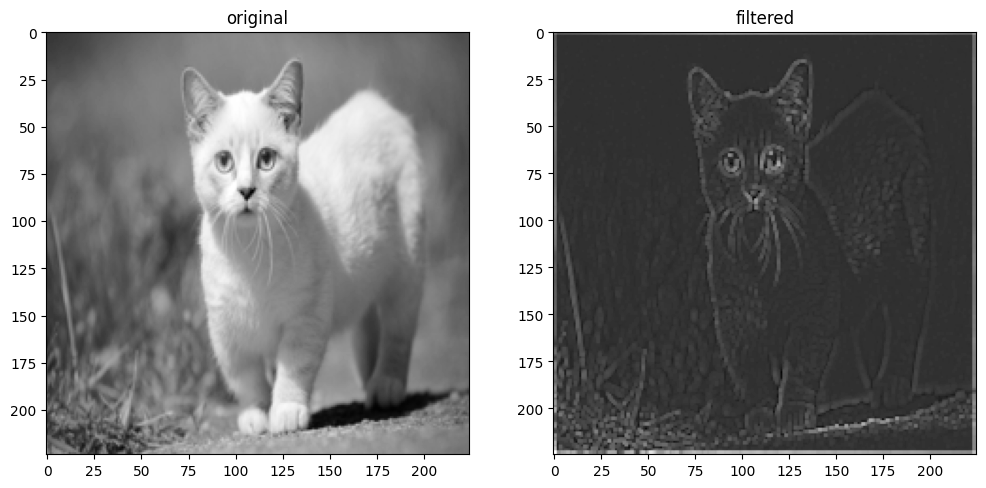

In [228]:
img = Image.open('./datasets/cat.jpeg')
img = ImageOps.grayscale(img)
img = img.resize(size=(224, 224))
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("original")
plt.imshow(img,cmap='gray')
output=conv2d(Input=np.array(img),kernel=outline,padding='same')
output=pool2d(output,padding='same',pool_type='max')
output=np.array(min_max_norm(output,mn=0,mx=255),np.int32)
plt.subplot(1,2,2)
plt.title("filtered")
plt.imshow(output,cmap='gray')

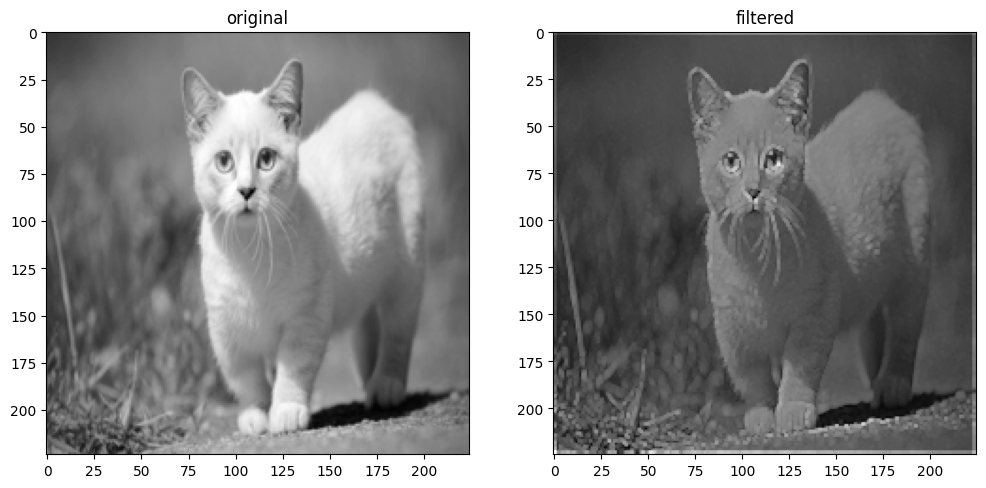

In [229]:
img = Image.open('./datasets/cat.jpeg')
img = ImageOps.grayscale(img)
img = img.resize(size=(224, 224))
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("original")
plt.imshow(img,cmap='gray')
output=conv2d(Input=np.array(img),kernel=sharpen,padding='same')
output=pool2d(output,padding='same',pool_type='max')
output=np.array(min_max_norm(output,mn=0,mx=255),np.int32)
plt.subplot(1,2,2)
plt.title("filtered")
plt.imshow(output,cmap='gray')

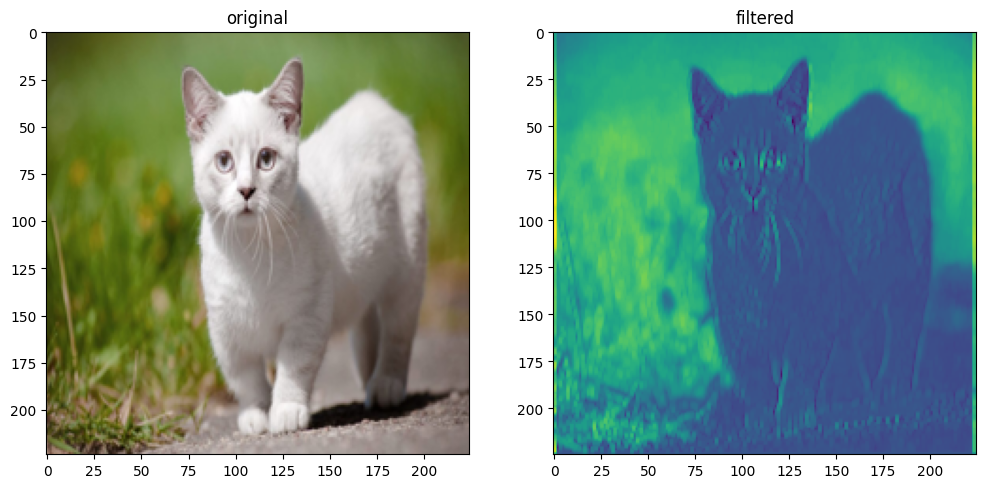

In [230]:
img = Image.open('./datasets/cat.jpeg')
img = img.resize(size=(224,224))
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("original")
plt.imshow(img)

output=conv2d(Input=np.array(img),kernel=get_multi_channel_kernel(outline,3),padding='same')
output=pool2d(output,padding='same',pool_type='max')
output=np.array(min_max_norm(output,mn=0,mx=255),np.int32)
plt.subplot(1,2,2)
plt.title("filtered")
plt.imshow(output)

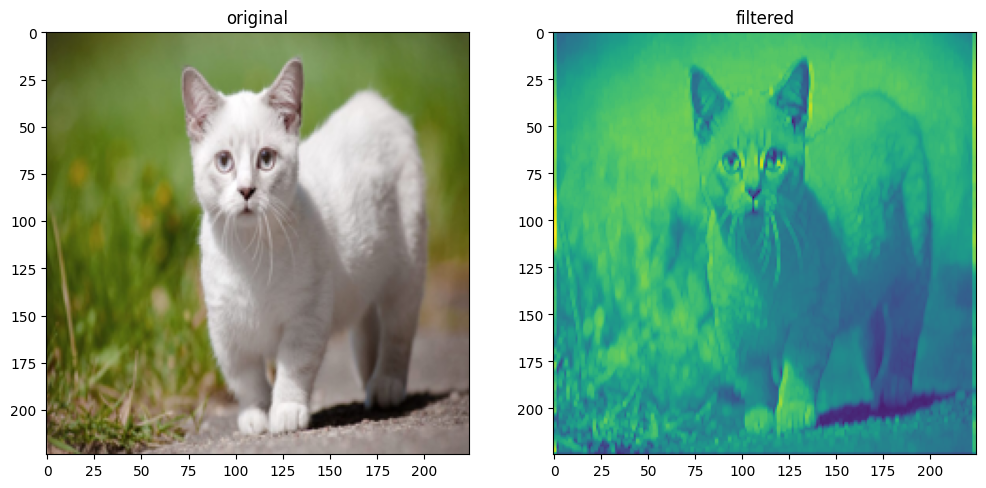

In [231]:
img = Image.open('./datasets/cat.jpeg')
img = img.resize(size=(224,224))
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("original")
plt.imshow(img)

output=conv2d(Input=np.array(img),kernel=get_multi_channel_kernel(sharpen,3),padding='same')
output=pool2d(output,padding='same',pool_type='max')
output=np.array(min_max_norm(output,mn=0,mx=255),np.int32)
plt.subplot(1,2,2)
plt.title("filtered")
plt.imshow(output)